These experiments were run using two files.

Firstly `continuous.sh` and `train.py`.

Each instance of `train.py` ran a algorithm in a envinronment one time.

To get 10 seeds per environment with 9 envrionments and 3 algorithms there are a total of 270 runs that need to be done.

The 270 runs were completed across two job submissions 1-90 and 91-270.

In [83]:
import os
import numpy as np
import pandas as pd
from itertools import product, chain
import re

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Getting the results

A slight error in the `train.py` code meant that a large chunk of the results had the labels ppo and sac switched, which resulted in the first attempt at the experiments to fail. The result is that the results are split into three different directories from three different grid jobs. Each grid output directory will ony be used to get a single model type from.

In [113]:
trad_algos = [
    ## First set of basic experiments
    "4676490_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 td3 with paper hyperparameters. problem with SAC and PPO mislabeled so we ignore the SAC (which are actually PPO results)
    "4676492_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 PPO with paper hyperparameters
    "4676867_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 SAC with paper hyperparameters

    # Rerunning some experiments with more timesteps as the final performance was not on par with paper: "Policy ensemble gradient for continuous control problems in deep reinforcement learning" baseline experiments
    "4677137_rl_older_env_benchmarks", # 2 million timesteps on ant environment using SB3 SAC to see if it learns better with more timesteps
    "4677138_rl_older_env_benchmarks", # 2 million timesteps with SB3 TD3 on hopper and swimmer 
    "4677139_rl_older_env_benchmarks", # 2 millions steps with SB3 TD3 on Ant
]

sota_algos = [
    "4677441_tqc_3mil_test", # 3 million time steps using authors original pytorch code and hyperparameters
    "4677444_redq_1mil", # 1 milliion timesteps using authors original pytorch code and hyperparameters
    "4678117_redq_1mil_second_attempt", # Rerunning and GRID engine dropped all the jobs
    "4678116_tqc_3mil_second_attempt" # Rerunning most as the GRID engines had problems with the jobs. A task id mapper was needed as seen below.
]

# The task id is used by the grid engine to run mulitple jobs each with a different experiemnt e.g envs and logs etc.
# Sometime when expriments  fails they need to be rerun but only a somewhat random subset. So a mapper is made to take the given task id (goes from 1 to n) and map it to the task id of the failed experiment.
task_id_mapper = {
    sota_algos[3]:  [
        6, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
        31, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 57, 58, 
        59, 60, 62, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 
        88, 89
    ]
}

grid_output_dir = "/home/thompsjame1/grid-output"
results_dirs = [
    os.path.join(grid_output_dir, d) for d in trad_algos + sota_algos
]

results_dirs

['/home/thompsjame1/grid-output/4676490_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4676492_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4676867_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4677137_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677138_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677139_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677441_tqc_3mil_test',
 '/home/thompsjame1/grid-output/4677444_redq_1mil',
 '/home/thompsjame1/grid-output/4678117_redq_1mil_second_attempt',
 '/home/thompsjame1/grid-output/4678116_tqc_3mil_second_attempt']

In [114]:
def convert_combo_to_number(model, env, seed, total_steps=None, mapper=None):
    """
    Convert a model, env and seed combindation to the task number that is used fro a grid submission
    """

    models = [
        "tqc",
        "redq",
        "ppo",
        "sac",
        "td3",
    ]

    envs = [
        "HalfCheetah-v5",
        "Walker2d-v5",
        "Humanoid-v5",
        "Ant-v5",
        "HumanoidStandup-v5",
        "Swimmer-v5",
        "Hopper-v5",
        "InvertedDoublePendulum-v5",
        "Pusher-v5",
    ]

    task_id =(0 if models.index(model) < 2 else models.index(model)-2) * 90 + envs.index(env) * 10 + int(seed)

    if mapper is not None:
        task_id = mapper.index(task_id)
    else: 
        task_id = task_id + 1

    return task_id
    
def get_experiment_details(eval_path):
    """
    Take a name of an experiment and get the details from it.
    Assuming the evaluation file is in the format:
    <model>_<env>_<total_steps>_<seed>.npz
    """
    eval_name = eval_path.split('/')[-1]
    model = eval_name.split('_')[0]
    env = eval_name.split('_')[1]
    steps = eval_name.split('_')[2]
    seed = eval_name.split('_')[3].split('.')[0]

    return {
        "model": model,
        "env": env,
        "total_steps": steps,
        "seed": seed
    }
    
def get_details(results_dir):
    """
    Take a results direcrtory and get all the experiment details from it.
    """
    evaluation_files = [os.path.join(results_dir, "training_evaluations", f) for f in os.listdir(os.path.join(results_dir, "training_evaluations"))]

    experiment_details = list(map(get_experiment_details, evaluation_files))

    mapper = task_id_mapper.get(results_dir.split("/")[-1], None)
    task_numbers = list(map(lambda x: convert_combo_to_number(**x, mapper=mapper), experiment_details))

    log_files = [os.path.join(results_dir, "logs", f"{f}_stdout.txt") for f in task_numbers]
    
    experiment_details = [
        {
            "evals": evals,
            "logs": logs,
            "details": details,
        }
        for details, logs, evals in zip(experiment_details, log_files, evaluation_files)
    ]
    return experiment_details

In [115]:
def load_experiments_into_df(result_dirs):
    """
    Load a collection of numpy archive paths into a pandas dataframe.
    It will perform error checking to make sure that all the files are valid and exist as expected.
    It is assumed that the numpy archives have the sample structure with three arrays:
    - 'timesteps': the number of timesteps at evaluations
    - 'results': the rewards at each evaluation
    - 'ep_lengths': the episode lengths at each evaluation
    """
    successful_results, failed_results = [], []

    for experiment in chain.from_iterable(map(get_details, result_dirs)):
        ### Unpacking the evaluation details ###

        try:
            npz = np.load(experiment['evals'])
        except EOFError as e:
            print(f"Failed to load evaluations at {experiment['evals']}: {e}")
            failed_results.append(experiment)
            continue

        evaluation_details = {
            'timesteps': npz['timesteps'],
            'rewards': npz['results'],
            'ep_lengths': npz['ep_lengths'],
            'last_evaluation': npz['timesteps'][-1],
        }

        ### Unpacking the log details ###

        try:
            with open(experiment['logs'], 'r') as f:
                logs = f.readlines()
        except FileNotFoundError as e:
            print(f"Failed to load log at {experiment['logs']}: {e}")
            failed_results.append(experiment)
            continue

        elapsed_seconds = re.search(r"Elapsed seconds: (\d+)", "\n".join(logs))
        if elapsed_seconds is not None:
            elapsed_hours = int(elapsed_seconds.group(1)) / 3600
        else:
            elapsed_hours = None


        ### Adding the details togather ###

        successful_results.append({
            **experiment['details'],
            **evaluation_details,
            "wall_time": elapsed_hours,
        })

    return pd.DataFrame(successful_results), pd.DataFrame(failed_results)

df, failed_df = load_experiments_into_df(results_dirs)
df

Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Swimmer-v5_3000000_0.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Hopper-v5_3000000_5.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Humanoid-v5_3000000_9.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Walker2d-v5_3000000_1.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Hopper-v5_3000000_6.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_HalfCheetah-v5_3000000_8.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,td3,Pusher-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-48.952695, -53.395769, -50.194313, -52.6373...","[[100, 100, 100, 100, 100, 100, 100, 100, 100,...",1000000,NaN
1,td3,Swimmer-v5,1000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-21.819346, -18.154842, -8.299162, -13.42011...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
2,td3,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[66400.32469, 73734.524948, 60710.972227, 486...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
3,sac,Hopper-v5,1000000,3,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[50.358669, 50.412393, 52.065304, 52.538533, ...","[[31, 31, 32, 32, 32, 32, 31, 32, 32, 32], [68...",1000000,NaN
4,sac,Walker2d-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[81.290282, 82.688121, 84.528785, 82.77355, 8...","[[102, 113, 103, 109, 105, 105, 99, 107, 114, ...",1001000,NaN
...,...,...,...,...,...,...,...,...,...
504,tqc,Humanoid-v5,3000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[92.06776341551326, 91.6687093377923, 92.1125...","[[19, 19, 19, 19, 19, 19, 19, 19, 19, 19], [18...",2481000,NaN
505,tqc,Ant-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[984.1189920517833, 984.2001639143737, 990.86...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,NaN
506,tqc,Hopper-v5,3000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[82.6620504860522, 77.96752919585344, 77.4402...","[[54, 51, 51, 52, 51, 55, 52, 53, 52, 52], [34...",347000,NaN
507,tqc,Hopper-v5,3000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[64.41859870498422, 65.70405969595026, 67.748...","[[40, 41, 42, 41, 41, 41, 41, 41, 42, 42], [43...",525000,NaN


In [116]:
# Find duplicate env, algo and seed combos

duplicates = df[df.duplicated(subset=['model', 'env', 'seed'], keep=False)]

# Only keep the ones with the duplicated with the highest total_steps
duplicates = duplicates.sort_values('last_evaluation', ascending=False)
duplicates = duplicates.drop_duplicates(subset=['model', 'env', 'seed'], keep='first')
duplicates

# Drop duplicates from the original dataframe
df = df.sort_values('total_steps', ascending=False).drop_duplicates(subset=['model', 'env', 'seed'], keep='first')
# Reseort by index
df = df.sort_index()
df

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,td3,Pusher-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-48.952695, -53.395769, -50.194313, -52.6373...","[[100, 100, 100, 100, 100, 100, 100, 100, 100,...",1000000,NaN
2,td3,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[66400.32469, 73734.524948, 60710.972227, 486...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
6,td3,Humanoid-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[106.709213, 106.256858, 100.583666, 100.0033...","[[22, 22, 21, 21, 22, 21, 22, 21, 21, 22], [15...",1000000,NaN
9,td3,HalfCheetah-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.036032, -2.527246, -2.147158, -1.283904, ...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
12,td3,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[40419.849108, 41418.488874, 37946.688939, 43...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
...,...,...,...,...,...,...,...,...,...
504,tqc,Humanoid-v5,3000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[92.06776341551326, 91.6687093377923, 92.1125...","[[19, 19, 19, 19, 19, 19, 19, 19, 19, 19], [18...",2481000,NaN
505,tqc,Ant-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[984.1189920517833, 984.2001639143737, 990.86...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,NaN
506,tqc,Hopper-v5,3000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[82.6620504860522, 77.96752919585344, 77.4402...","[[54, 51, 51, 52, 51, 55, 52, 53, 52, 52], [34...",347000,NaN
507,tqc,Hopper-v5,3000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[64.41859870498422, 65.70405969595026, 67.748...","[[40, 41, 42, 41, 41, 41, 41, 41, 42, 42], [43...",525000,NaN


# Validating the results

I would like to validate two things abotu the results.

1. That the model types are actually waht they say they are.
2. That the correct number of runs and seeds have been run

In [120]:
## Check to see if the amount of runs matches the expected time steps.
df_removed_uncompleted = df[df['total_steps'].astype(int) <= df['last_evaluation']]

df_removed_uncompleted

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,td3,Pusher-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-48.952695, -53.395769, -50.194313, -52.6373...","[[100, 100, 100, 100, 100, 100, 100, 100, 100,...",1000000,NaN
2,td3,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[66400.32469, 73734.524948, 60710.972227, 486...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
6,td3,Humanoid-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[106.709213, 106.256858, 100.583666, 100.0033...","[[22, 22, 21, 21, 22, 21, 22, 21, 21, 22], [15...",1000000,NaN
9,td3,HalfCheetah-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.036032, -2.527246, -2.147158, -1.283904, ...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
12,td3,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[40419.849108, 41418.488874, 37946.688939, 43...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
...,...,...,...,...,...,...,...,...,...
494,tqc,Swimmer-v5,3000000,3,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[49.44530197989511, 48.60102059648457, 45.589...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,91.461667
495,tqc,Swimmer-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[40.8193069217581, 39.49981103399878, 38.5528...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,NaN
501,tqc,Humanoid-v5,3000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[122.69938124692591, 122.24132814510324, 116....","[[25, 25, 24, 25, 24, 25, 25, 24, 24, 25], [19...",3000000,NaN
505,tqc,Ant-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[984.1189920517833, 984.2001639143737, 990.86...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,NaN


## Make sure that the correct number of experiemnts per model env pair are made

Each environment and model pair needs to be run 10 times. Due to running this on a grid-solar system there is not guarentees that the experiment will complete.

In [121]:
# Count number of seeds per model and env
df_removed_uncompleted.groupby(['model', 'env']).count()

total_steps  seed  timesteps  rewards  \
model env                                                                
ppo   Ant-v5                              10    10         10       10   
      HalfCheetah-v5                      10    10         10       10   
      Hopper-v5                           10    10         10       10   
      Humanoid-v5                         10    10         10       10   
      HumanoidStandup-v5                  10    10         10       10   
      InvertedDoublePendulum-v5           10    10         10       10   
      Pusher-v5                           10    10         10       10   
      Swimmer-v5                          10    10         10       10   
      Walker2d-v5                         10    10         10       10   
redq  HumanoidStandup-v5                   2     2          2        2   
      Swimmer-v5                           3     3          3        3   
sac   Ant-v5                               9     9          9        9   
      HalfCheetah-v5                      10    10         10       10   
      Hopper-v5                           10    10         10       10   
      Humanoid-v5                         10    10         10       10   
      HumanoidStandup-v5                  10    10         10       10   
      InvertedDoublePendulum-v5           10    10         10       10   
      Pusher-v5                           10    10         10       10   
      Swimmer-v5                          10    10         10       10   
      Walker2d-v5                         10    10         10       10   
td3   Ant-v5                              10    10         10       10   
      HalfCheetah-v5                      10    10         10       10   
      Hopper-v5                           10    10         10       10   
      Humanoid-v5                         10    10         10       10   
      HumanoidStandup-v5                  10    10         10       10   
      InvertedDoublePendulum-v5           10    10         10       10   
      Pusher-v5                           10    10         10       10   
      Swimmer-v5                          10    10         10       10   
      Walker2d-v5                         10    10         10       10   
tqc   Ant-v5                               8     8          8        8   
      HalfCheetah-v5                       7     7          7        7   
      Hopper-v5                            2     2          2        2   
      Humanoid-v5                          1     1          1        1   
      InvertedDoublePendulum-v5            5     5          5        5   
      Pusher-v5                            2     2          2        2   
      Swimmer-v5                           5     5          5        5   
      Walker2d-v5                          2     2          2        2   

                                 ep_lengths  last_evaluation  wall_time  
model env                                                                
ppo   Ant-v5                             10               10          0  
      HalfCheetah-v5                     10               10          0  
      Hopper-v5                          10               10          0  
      Humanoid-v5                        10               10          0  
      HumanoidStandup-v5                 10               10          0  
      InvertedDoublePendulum-v5          10               10          0  
      Pusher-v5                          10               10          0  
      Swimmer-v5                         10               10          0  
      Walker2d-v5                        10               10          0  
redq  HumanoidStandup-v5                  2                2          2  
      Swimmer-v5                          3                3          3  
sac   Ant-v5                              9                9          0  
      HalfCheetah-v5                     10               10          0  
      Hopper-v5                     

In [45]:
def get_missing_runs(df):
    """
    Get the environment model and seed combindations that are missing from the dataframe
    """
    models = df['model'].unique()
    envs = df['env'].unique()
    seeds = df['seed'].unique()

    expected_combinations = list(product(models, envs, seeds))
    print(f"Expected combinations: {expected_combinations}")

    completed_combinations = [tuple(comb) for comb in df[['model', 'env', 'seed']].values.tolist()]
    print(f"Completed combinations: {completed_combinations}")

    missing_combinations = [comb for comb in expected_combinations if comb not in completed_combinations]

    return missing_combinations

missing_combinations = get_missing_runs(df_removed_uncompleted)
len(missing_combinations), missing_combinations

Expected combinations: [('td3', 'Pusher-v5', '8'), ('td3', 'Pusher-v5', '9'), ('td3', 'Pusher-v5', '6'), ('td3', 'Pusher-v5', '5'), ('td3', 'Pusher-v5', '2'), ('td3', 'Pusher-v5', '1'), ('td3', 'Pusher-v5', '0'), ('td3', 'Pusher-v5', '4'), ('td3', 'Pusher-v5', '3'), ('td3', 'Pusher-v5', '7'), ('td3', 'HumanoidStandup-v5', '8'), ('td3', 'HumanoidStandup-v5', '9'), ('td3', 'HumanoidStandup-v5', '6'), ('td3', 'HumanoidStandup-v5', '5'), ('td3', 'HumanoidStandup-v5', '2'), ('td3', 'HumanoidStandup-v5', '1'), ('td3', 'HumanoidStandup-v5', '0'), ('td3', 'HumanoidStandup-v5', '4'), ('td3', 'HumanoidStandup-v5', '3'), ('td3', 'HumanoidStandup-v5', '7'), ('td3', 'Humanoid-v5', '8'), ('td3', 'Humanoid-v5', '9'), ('td3', 'Humanoid-v5', '6'), ('td3', 'Humanoid-v5', '5'), ('td3', 'Humanoid-v5', '2'), ('td3', 'Humanoid-v5', '1'), ('td3', 'Humanoid-v5', '0'), ('td3', 'Humanoid-v5', '4'), ('td3', 'Humanoid-v5', '3'), ('td3', 'Humanoid-v5', '7'), ('td3', 'HalfCheetah-v5', '8'), ('td3', 'HalfCheetah-v5'

(145,
 [('sac', 'Ant-v5', '2'),
  ('tqc', 'Pusher-v5', '8'),
  ('tqc', 'Pusher-v5', '9'),
  ('tqc', 'Pusher-v5', '5'),
  ('tqc', 'Pusher-v5', '2'),
  ('tqc', 'Pusher-v5', '1'),
  ('tqc', 'Pusher-v5', '0'),
  ('tqc', 'Pusher-v5', '4'),
  ('tqc', 'Pusher-v5', '3'),
  ('tqc', 'HumanoidStandup-v5', '8'),
  ('tqc', 'HumanoidStandup-v5', '9'),
  ('tqc', 'HumanoidStandup-v5', '6'),
  ('tqc', 'HumanoidStandup-v5', '5'),
  ('tqc', 'HumanoidStandup-v5', '2'),
  ('tqc', 'HumanoidStandup-v5', '1'),
  ('tqc', 'HumanoidStandup-v5', '0'),
  ('tqc', 'HumanoidStandup-v5', '4'),
  ('tqc', 'HumanoidStandup-v5', '3'),
  ('tqc', 'HumanoidStandup-v5', '7'),
  ('tqc', 'Humanoid-v5', '8'),
  ('tqc', 'Humanoid-v5', '9'),
  ('tqc', 'Humanoid-v5', '6'),
  ('tqc', 'Humanoid-v5', '5'),
  ('tqc', 'Humanoid-v5', '2'),
  ('tqc', 'Humanoid-v5', '1'),
  ('tqc', 'Humanoid-v5', '0'),
  ('tqc', 'Humanoid-v5', '4'),
  ('tqc', 'Humanoid-v5', '3'),
  ('tqc', 'HalfCheetah-v5', '8'),
  ('tqc', 'HalfCheetah-v5', '6'),
  ('tqc',

In [46]:
missing_nums = [convert_combo_to_number(*combo) for combo in missing_combinations]
missing_nums.sort()
missing_nums

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 10,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 15,
 15,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 20,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 25,
 25,
 26,
 26,
 27,
 27,
 28,
 29,
 29,
 30,
 30,
 31,
 32,
 33,
 34,
 35,
 35,
 36,
 36,
 37,
 38,
 39,
 40,
 41,
 41,
 42,
 42,
 43,
 43,
 44,
 44,
 45,
 45,
 46,
 46,
 47,
 47,
 48,
 49,
 50,
 50,
 51,
 51,
 52,
 53,
 54,
 54,
 55,
 55,
 57,
 58,
 59,
 59,
 60,
 61,
 61,
 62,
 63,
 63,
 64,
 65,
 65,
 66,
 66,
 67,
 67,
 68,
 68,
 69,
 69,
 70,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 76,
 77,
 77,
 78,
 78,
 79,
 79,
 80,
 80,
 81,
 81,
 82,
 82,
 83,
 83,
 84,
 84,
 85,
 85,
 86,
 86,
 87,
 88,
 89,
 89,
 90,
 90,
 123]

# Visualizing the results

## Learning curves

In [47]:
df_grouped = df.explode(['timesteps', 'rewards']).groupby(['model', 'env', 'timesteps']).agg({
    "rewards": lambda x: np.vstack(x),
}).reset_index()
df_grouped

,model,env,timesteps,rewards
0,ppo,Ant-v5,1000,"[[994.002296, 992.628523, 995.069539, 988.2331..."
1,ppo,Ant-v5,2000,"[[997.553241, 996.017129, 998.635264, 994.9632..."
2,ppo,Ant-v5,3000,"[[987.076178, 987.289457, 987.211626, 988.9279..."
3,ppo,Ant-v5,4000,"[[990.587657, 990.176489, 985.988487, 989.6232..."
4,ppo,Ant-v5,5000,"[[978.307347, 985.207296, 982.196496, 979.1563..."
...,...,...,...,...
62312,tqc,Walker2d-v5,2996000,"[[6469.95084545808, 6558.950047949435, 6413.62..."
62313,tqc,Walker2d-v5,2997000,"[[358.92436463660925, 6525.366503172048, 6547...."
62314,tqc,Walker2d-v5,2998000,"[[6469.128324953206, 6473.970026518167, 6472.4..."
62315,tqc,Walker2d-v5,2999000,"[[6464.3824404794805, 6441.599181737605, 339.7..."


In [48]:
def add_mean_ci(df, ci, axis=None): 
    df["mean_rewards"] = df["rewards"].apply(lambda x: np.mean(x, axis=axis))
    ci = 85
    df['upper_ci'] = df['rewards'].apply(lambda x: np.percentile(x, ci, axis=axis))
    df['lower_ci'] = df['rewards'].apply(lambda x: np.percentile(x, 100-ci, axis=axis))
    return df

df_grouped = add_mean_ci(df_grouped, 85)

df_grouped

,model,env,timesteps,rewards,mean_rewards,upper_ci,lower_ci
0,ppo,Ant-v5,1000,"[[994.002296, 992.628523, 995.069539, 988.2331...",993.814065,997.161469,989.187537
1,ppo,Ant-v5,2000,"[[997.553241, 996.017129, 998.635264, 994.9632...",994.207132,998.331642,989.682483
2,ppo,Ant-v5,3000,"[[987.076178, 987.289457, 987.211626, 988.9279...",987.942770,992.277269,981.427154
3,ppo,Ant-v5,4000,"[[990.587657, 990.176489, 985.988487, 989.6232...",988.130807,993.087112,982.276771
4,ppo,Ant-v5,5000,"[[978.307347, 985.207296, 982.196496, 979.1563...",984.505891,994.996968,977.830133
...,...,...,...,...,...,...,...
62312,tqc,Walker2d-v5,2996000,"[[6469.95084545808, 6558.950047949435, 6413.62...",6364.924786,6505.845613,6265.177991
62313,tqc,Walker2d-v5,2997000,"[[358.92436463660925, 6525.366503172048, 6547....",6015.685852,6530.118806,6101.314506
62314,tqc,Walker2d-v5,2998000,"[[6469.128324953206, 6473.970026518167, 6472.4...",6375.360324,6540.438827,6253.653870
62315,tqc,Walker2d-v5,2999000,"[[6464.3824404794805, 6441.599181737605, 339.7...",4501.522563,6426.978036,371.369438


In [49]:
from scipy.signal import savgol_filter

# Add a smoothing function using Savitzky-Golay
def smooth_savgol(data, window_size=50, polyorder=2):
    # Ensure the window size is smaller than the data length
    if len(data) < window_size:
        window_size = len(data) if len(data) % 2 == 1 else len(data) - 1  # Ensure window size is odd
    return savgol_filter(data, window_size, polyorder)

# Apply smoothing to each group
def apply_smoothing(group):
    group = group.sort_values("timesteps")  # Ensure data is sorted by x-axis (env_steps)
    group["smoothed_mean_rewards"] = smooth_savgol(group["mean_rewards"])
    group["smoothed_upper_ci"] = smooth_savgol(group["upper_ci"])
    group["smoothed_lower_ci"] = smooth_savgol(group["lower_ci"])
    return group

# Group by model, algo, and env, and apply smoothing
df_smoothed = df_grouped.groupby(["model", "env"]).apply(apply_smoothing)

df_smoothed

/tmp/ipykernel_1909083/758811617.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df_grouped.groupby(["model", "env"]).apply(apply_smoothing)


model          env  timesteps  \
model env                                               
ppo   Ant-v5      0       ppo       Ant-v5       1000   
                  1       ppo       Ant-v5       2000   
                  2       ppo       Ant-v5       3000   
                  3       ppo       Ant-v5       4000   
                  4       ppo       Ant-v5       5000   
...                       ...          ...        ...   
tqc   Walker2d-v5 62312   tqc  Walker2d-v5    2996000   
                  62313   tqc  Walker2d-v5    2997000   
                  62314   tqc  Walker2d-v5    2998000   
                  62315   tqc  Walker2d-v5    2999000   
                  62316   tqc  Walker2d-v5    3000000   

                                                                   rewards  \
model env                                                                    
ppo   Ant-v5      0      [[994.002296, 992.628523, 995.069539, 988.2331...   
                  1      [[997.553241, 996.017129, 998.635264, 994.9632...   
                  2      [[987.076178, 987.289457, 987.211626, 988.9279...   
                  3      [[990.587657, 990.176489, 985.988487, 989.6232...   
                  4      [[978.307347, 985.207296, 982.196496, 979.1563...   
...                                                                    ...   
tqc   Walker2d-v5 62312  [[6469.95084545808, 6558.950047949435, 6413.62...   
                  62313  [[358.92436463660925, 6525.366503172048, 6547....   
                  62314  [[6469.128324953206, 6473.970026518167, 6472.4...   
                  62315  [[6464.3824404794805, 6441.599181737605, 339.7...   
                  62316  [[6491.661589476861, 6531.004099275907, 6492.8...   

                         mean_rewards     upper_ci     lower_ci  \
model env                                                         
ppo   Ant-v5      0        993.814065   997.161469   989.187537   
                  1        994.207132   998.331642   989.682483   
                  2        987.942770   992.277269   981.427154   
                  3        988.130807   993.087112   982.276771   
                  4        984.505891   994.996968   977.830133   
...                               ...          ...          ...   
tqc   Walker2d-v5 62312   6364.924786  6505.845613  6265.177991   
                  62313   6015.685852  6530.118806  6101.314506   
                  62314   6375.360324  6540.438827  6253.653870   
                  62315   4501.522563  6426.978036   371.369438   
                  62316   5754.983880  6493.972275  6222.940525   

                         smoothed_mean_rewards  smoothed_upper_ci  \
model env                                                           
ppo   Ant-v5      0                1010.429734        1008.400956   
                  1                1006.300652        1006.733763   
                  2                1001.858263        1004.992203   
                  3                 997.102567        1003.176275   
                  4                 992.033563        1001.285980   
...                                        ...                ...   
tqc   Walker2d-v5 62312            5698.435814        6462.472857   
                  62313            5667.560295        6463.416005   
                  62314            5635.719600        6464.467858   
                  62315            5602.913729        6465.628419   
                  62316            5569.142681        6466.897686   

                         smoothed_lower_ci  
model env                                   
ppo   Ant-v5      0            1080.269027  
                  1            1064.641876  
                  2            1048.666713  
                  3            1032.343538  
                  4            1015.672351  
...                                    ...  
tqc   Walker2d-v5 62312        5008.647304  
                  62313        4961.482981  
                  62314        4913.530398  
  

In [110]:
def make_multi_plot(
        df,
        x_name,
        y_name,
        y_upper_name = "upper_ci",
        y_lower_name = "lower_ci",
        x_label = "Time steps",
        y_label = "Average Reward",
        envs = 'all',
        add_hline = False,
        envs_vline = None,
        save_name = None):
    """
    Makes a plot with multiple environments with multiple models in each envinronment.
    For each line it will add in the mean and the confidence intervals.
    Assumes that column models and envs are in the dataframe everything else is given.
    """
    if envs == 'all':
        envs = df['env'].unique()
    cols = 3
    rows = len(envs) // cols

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, (rows*3) + 1))
    axes = axes.flatten()

    line_handles = []
    line_labels = []

    for i, env in enumerate(envs):
        ax = axes[i]
        # Filter data for the current environment
        env_data = df[df["env"] == env]

        # Plot mean rewards
        for model in env_data["model"].unique():
            model_data = env_data[env_data["model"] == model]
            if len(model_data) == 1:
                model_data = model_data.iloc[0]
            
            line,  =ax.plot(
                model_data[x_name],
                model_data[y_name],
                label=model,
                alpha=0.7,
                linewidth=2,
            )

            # Plot confidence intervals
            ax.fill_between(
                model_data[x_name],
                model_data[y_lower_name],
                model_data[y_upper_name],
                alpha=0.2,
                color=line.get_color(),
            )


            if add_hline:
                # Add a horizontal bar at the height of the final mean reward
                final_mean_reward = model_data[y_name][-1]
                final_wall_clock = model_data[x_name][-1]
                
                final_wall_clock_axes = ax.transData.transform((final_wall_clock, 0))[0]  # Transform to display coordinates
                final_wall_clock_axes = ax.transAxes.inverted().transform((final_wall_clock_axes, 0))[0]  # Transform 
                ax.axhline(
                    xmin=final_wall_clock_axes,
                    y=final_mean_reward,
                    color=line.get_color(),
                    linestyle="--",
                    linewidth=1,
                    label=f"{model} final {y_label}",
                )

            
            if len(line_handles) < len(env_data["model"].unique()):
                line_handles.append(line)
                line_labels.append(model)

        if envs_vline is not None:
            ax.axvline(
                x=envs_vline[env],
                color='black',
                linestyle='--',
                linewidth=2,
                alpha=0.6,
                zorder=0,
                label=f"real {env} time",
            )

        # Set titles and labels
        ax.set_title(f'{env}')
        if i % cols == 0:  # Only show y-axis label on the first column
            ax.set_ylabel(y_label)
        if i >= (rows - 1) * cols:  # Only show x-axis label on the last row
            ax.set_xlabel(x_label)
        ax.grid(True)
    
    if envs_vline is not None:
        vline_legend = Line2D([0], [0], color='red', linestyle='--', linewidth=1, label="Environment time (vline)")
        line_handles.append(vline_legend)
        line_labels.append("Environment time (vline)")


    # Add legend
    fig.legend(
        handles=line_handles,
        labels=line_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),  # Position the legend below the grid
        ncol=len(line_labels),  # Arrange legend items in a single row
        fontsize=16,
    )

    if save_name is not None:
        fig.savefig(
            os.path.join('..', 'figures', f"{save_name}"),
            bbox_inches='tight',
            dpi=300,
        )

    return fig

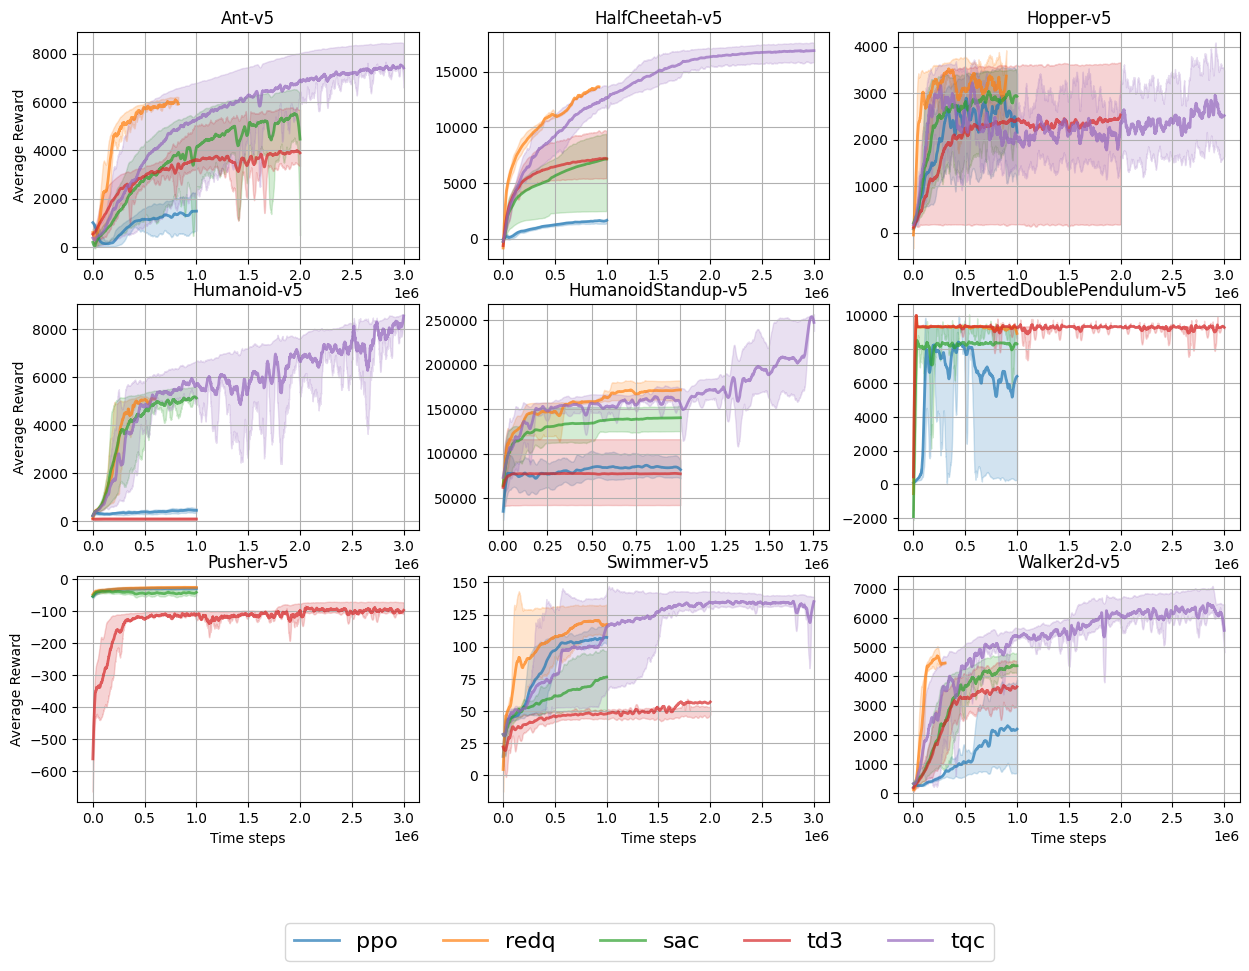

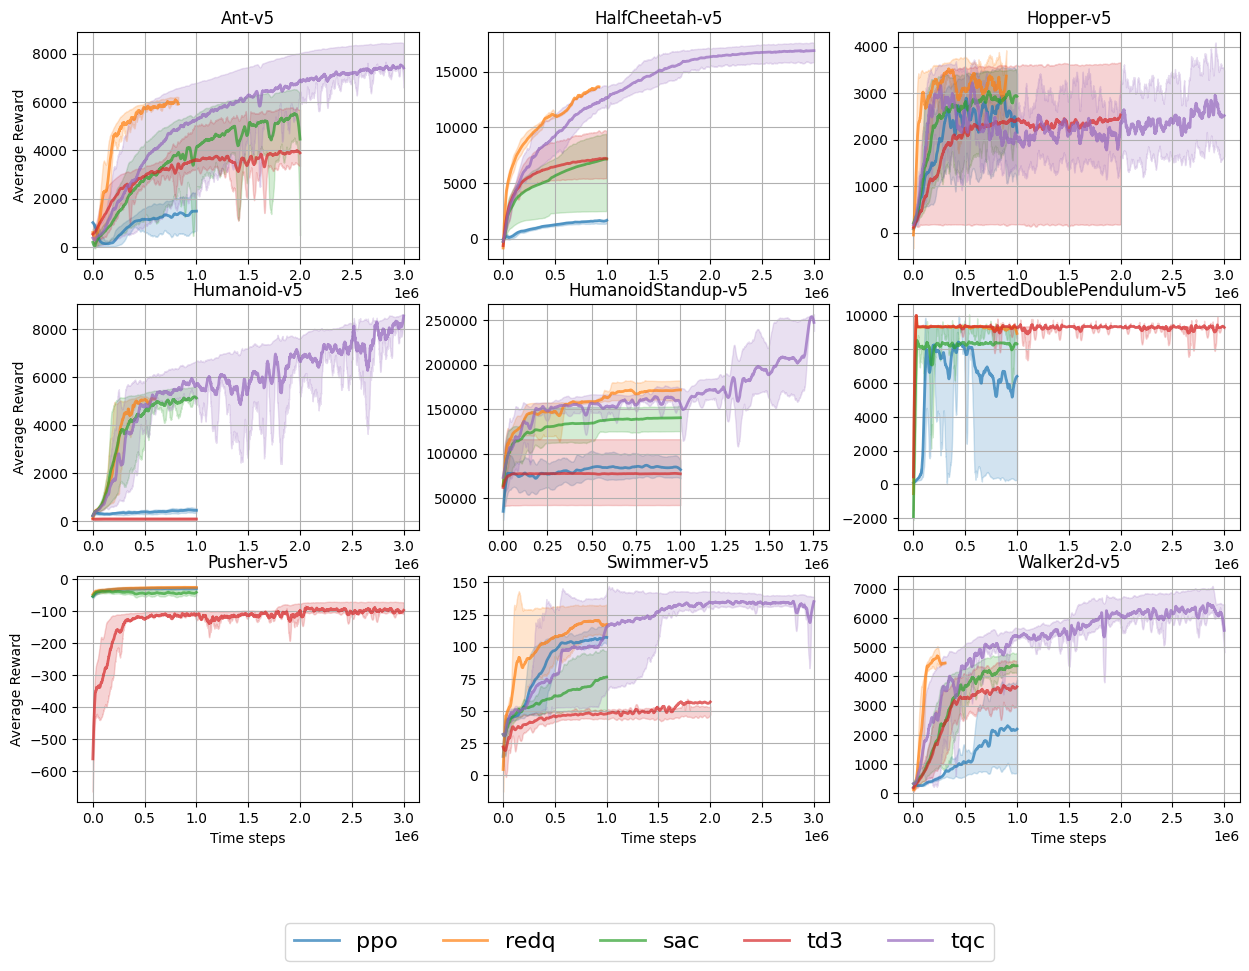

In [111]:
make_multi_plot(
    df_smoothed,
    x_name='timesteps',
    y_name='smoothed_mean_rewards',
    y_upper_name='smoothed_upper_ci',
    y_lower_name='smoothed_lower_ci',
    save_name="baseline_results",
)

### Comparing to PEG paper results

For these becnhmarks it is important that we get similar results to other papers.

In [52]:
PEG = {
    "td3": {
        "hopper": 3200,
        "swimmer": 57,
        "walker2d": 3700,
        "humanoid": 200,
        "ant": 4300,
        "humanoidstandup": 82000
    },
    "sac": {
        "hopper": 3200,
        "swimmer": 42,
        "walker2d": 4500,
        "humanoid": 5200,
        "ant": 5200,
        "humanoidstandup": 140000
    }
}

mine = {
    "td3": {
        "halfcheetah": 7000,
        "walker2d": 3500,
        "humanoid": 200,
        "ant": 3000,
        "humanoidstandup": 80000,
        "swimmer": 48,
        "hopper": 2600,
        "inverteddoublependulum": 8200,
        "pusher": -50
    },
    "sac": {
        "halfcheetah": 7000,
        "walker2d": 4500,
        "humanoid": 5000,
        "ant": 4200,
        "humanoidstandup": 140000,
        "swimmer": 80,
        "hopper": 3000,
        "inverteddoublependulum": 8200,
        "pusher": -30
    },
    "ppo": {
        "halfcheetah": 1800,
        "walker2d": 2100,
        "humanoid": 500,
        "ant": 1800,
        "humanoidstandup": 82500,
        "swimmer": 110,
        "hopper": 2500,
        "inverteddoublependulum": 600,
        "pusher": -30
    }
}



In [53]:
percentage_threshold = 10  # Adjust this value as needed (e.g., 20% difference)
def compare_results_with_percentage(other, mine, percentage_threshold):
    significant_differences = {}
    
    for algo in other:
        if algo in mine:
            for env, peg_value in other[algo].items():
                if env in mine[algo]:
                    mine_value = mine[algo][env]
                    if peg_value != 0:  # Avoid division by zero
                        percentage_diff = (peg_value - mine_value) / abs(peg_value) * 100
                        if percentage_diff > percentage_threshold:
                            if algo not in significant_differences:
                                significant_differences[algo] = {}
                            significant_differences[algo][env] = {
                                "PEG": peg_value,
                                "mine": mine_value,
                                "percentage_difference": percentage_diff
                            }
    return significant_differences

# Compare PEG and mine
significant_differences = compare_results_with_percentage(PEG, mine, percentage_threshold)

# Print the results
for algo, envs in significant_differences.items():
    print(f"Algorithm: {algo}")
    for env, values in envs.items():
        print(f"  Environment: {env}")
        print(f"    PEG paper Value: {values['PEG']}")
        print(f"    My hyperparameter Value: {values['mine']}")
        print(f"    Percentage Difference: {values['percentage_difference']:.2f}%")

Algorithm: td3
  Environment: hopper
    PEG paper Value: 3200
    My hyperparameter Value: 2600
    Percentage Difference: 18.75%
  Environment: swimmer
    PEG paper Value: 57
    My hyperparameter Value: 48
    Percentage Difference: 15.79%
  Environment: ant
    PEG paper Value: 4300
    My hyperparameter Value: 3000
    Percentage Difference: 30.23%
Algorithm: sac
  Environment: ant
    PEG paper Value: 5200
    My hyperparameter Value: 4200
    Percentage Difference: 19.23%


## Wall clock time

### Understanding environment time

In [96]:
import gymnasium as gym

def get_env_time(envs, length):
    envs_dt = [gym.make(env).env.unwrapped.dt for env in envs]
    print(envs_dt)
    envs_time_for_length = [(dt * length) / 3600 for dt in envs_dt]

    return {
        env: round(time, 2)
        for env, time in zip(envs, envs_time_for_length)
    } 

envs_time = get_env_time(df['env'].unique(), 1_000_000)

[0.05, 0.015, 0.015, 0.05, 0.008, 0.05, 0.05, 0.04, 0.008]


### Making plot

In [54]:
def cut_to_length(df, length=1_000_000):
    """
    Cut the dataframe experiemtns data to length
    """
    df = df.copy().dropna(subset=['wall_time'])

    num_evals = length // 1_000

    df['timesteps'] = df['timesteps'].apply(lambda x: x[x <= length])
    df['rewards'] = df['rewards'].apply(lambda x: x[:num_evals])
    df['ep_lengths'] = df['ep_lengths'].apply(lambda x: x[:num_evals])

    df['time_to_length'] = df['wall_time'] / df['last_evaluation'] * length
    df['wall_time_approx_steps'] = df['time_to_length'].apply(lambda x: np.linspace(0, x, num_evals))
    df.drop("last_evaluation", axis=1, inplace=True)

    return df

wall_clock_measurements = cut_to_length(df)
wall_clock_measurements

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,wall_time,time_to_length,wall_time_approx_steps
461,redq,Swimmer-v5,1000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-9.682355333707276, -11.442051299342591, -20...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",29.143889,29.143889,"[0.0, 0.029173061950839727, 0.0583461239016794..."
466,redq,HumanoidStandup-v5,1000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[93169.64751455454, 96963.02440865105, 77384....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",41.095000,41.095000,"[0.0, 0.041136136136136134, 0.0822722722722722..."
469,redq,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[44634.14531868548, 64214.09361104419, 36095....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",25.002778,25.002778,"[0.0, 0.025027805583361137, 0.0500556111667222..."
475,redq,Swimmer-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-16.66551454407179, -9.206144503648892, -27....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",43.776389,43.776389,"[0.0, 0.043820209097986874, 0.0876404181959737..."
482,redq,Swimmer-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-0.13189356671788788, -4.85574746793681, -1....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",43.779722,43.779722,"[0.0, 0.04382354576799021, 0.08764709153598042..."
493,tqc,Swimmer-v5,3000000,3,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[49.44530197989511, 48.60102059648457, 45.589...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",91.461667,30.538119,"[0.0, 0.03056868777514298, 0.06113737555028596..."
496,tqc,HumanoidStandup-v5,3000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[29633.347438283527, 30088.37564894468, 29905...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",19.495000,11.360723,"[0.0, 0.01137209470542804, 0.02274418941085608..."
502,tqc,HumanoidStandup-v5,3000000,4,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[31479.434579709712, 31549.749139476215, 3143...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",21.404444,19.458586,"[0.0, 0.01947806392250837, 0.03895612784501674..."
507,tqc,Ant-v5,3000000,3,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[976.3833487806032, 968.6006281058587, 972.78...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",14.840000,4.946667,"[0.0, 0.004951618284951619, 0.0099032365699032..."


In [55]:
merged_wall_clock_measurements = wall_clock_measurements.groupby(["model", "env"]).agg({
    'rewards': lambda x: [0] + np.hstack(x),
    'time_to_length': lambda x: np.mean(x),
    'wall_time_approx_steps': lambda x: x.iloc[0],
}).reset_index()

merged_wall_clock_measurements

,model,env,rewards,time_to_length,wall_time_approx_steps
0,redq,HumanoidStandup-v5,"[[93169.64751455454, 96963.02440865105, 77384....",33.048889,"[0.0, 0.041136136136136134, 0.0822722722722722..."
1,redq,Swimmer-v5,"[[-9.682355333707276, -11.442051299342591, -20...",38.900000,"[0.0, 0.029173061950839727, 0.0583461239016794..."
2,tqc,Ant-v5,"[[976.3833487806032, 968.6006281058587, 972.78...",4.946667,"[0.0, 0.004951618284951619, 0.0099032365699032..."
3,tqc,HumanoidStandup-v5,"[[29633.347438283527, 30088.37564894468, 29905...",15.409654,"[0.0, 0.01137209470542804, 0.02274418941085608..."
4,tqc,Swimmer-v5,"[[49.44530197989511, 48.60102059648457, 45.589...",30.538119,"[0.0, 0.03056868777514298, 0.06113737555028596..."


In [95]:
merged_wall_clock_measurements = add_mean_ci(merged_wall_clock_measurements, 85, 1)
merged_wall_clock_measurements

,model,env,rewards,time_to_length,wall_time_approx_steps,mean_rewards,upper_ci,lower_ci
0,redq,HumanoidStandup-v5,"[[93169.64751455454, 96963.02440865105, 77384....",33.048889,"[0.0, 0.041136136136136134, 0.0822722722722722...","[67887.55274175963, 64433.288915774334, 66969....","[96355.29242871086, 97542.78636811218, 98307.5...","[43382.153329504734, 36399.04708880266, 39202...."
1,redq,Swimmer-v5,"[[-9.682355333707276, -11.442051299342591, -20...",38.900000,"[0.0, 0.029173061950839727, 0.0583461239016794...","[-10.38788413319938, -10.165540098856017, -10....","[1.9548065314364815, 2.757580128068431, 2.0843...","[-20.80289719183873, -21.81283271254185, -21.1..."
2,tqc,Ant-v5,"[[976.3833487806032, 968.6006281058587, 972.78...",4.946667,"[0.0, 0.004951618284951619, 0.0099032365699032...","[971.9597988277877, 729.574571457739, 465.2572...","[975.1530368020842, 754.6103920604149, 574.924...","[968.972458816535, 707.7967641633601, 369.6960..."
3,tqc,HumanoidStandup-v5,"[[29633.347438283527, 30088.37564894468, 29905...",15.409654,"[0.0, 0.01137209470542804, 0.02274418941085608...","[30619.62492463955, 82588.92572791164, 70664.0...","[31554.3270045627, 93858.39989644114, 106970.7...","[29613.936133202442, 71783.24820423144, 47331...."
4,tqc,Swimmer-v5,"[[49.44530197989511, 48.60102059648457, 45.589...",30.538119,"[0.0, 0.03056868777514298, 0.06113737555028596...","[45.92845122661752, 31.794542469267913, 25.314...","[48.41426588703808, 32.5332009902934, 26.34883...","[42.887608183407224, 30.595970914927054, 23.88..."


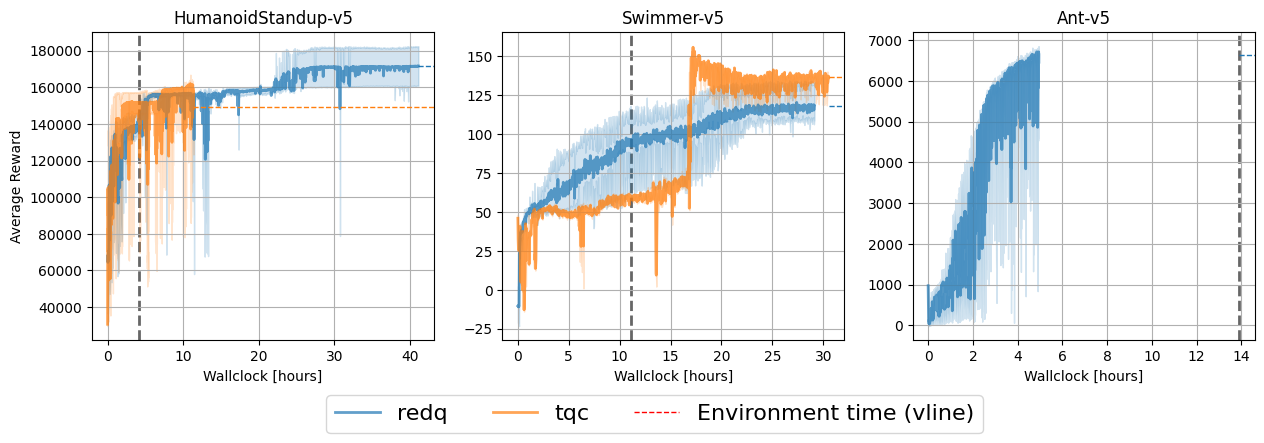

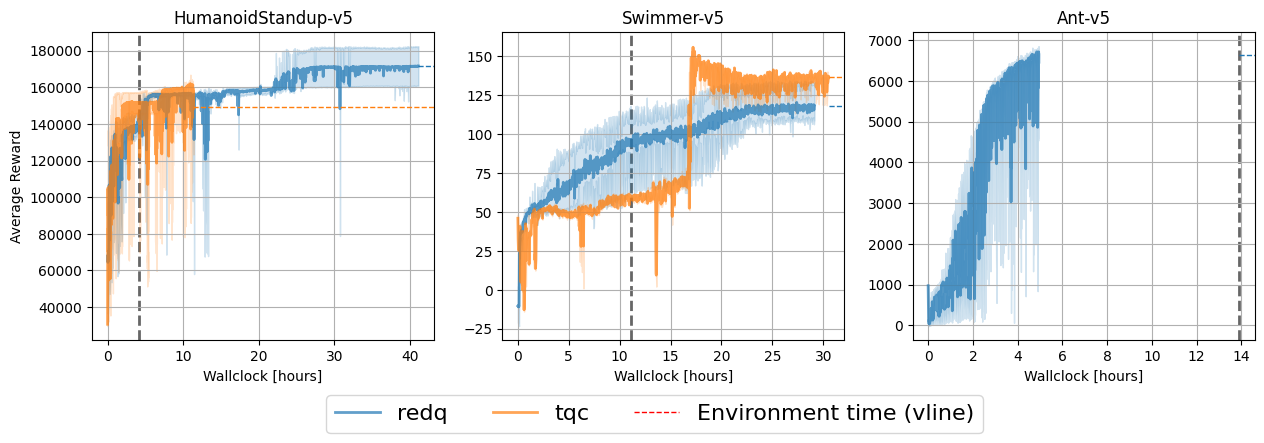

In [112]:
make_multi_plot(
    merged_wall_clock_measurements,
    x_name='wall_time_approx_steps',
    y_name='mean_rewards',
    y_upper_name='upper_ci',
    y_lower_name='lower_ci',
    x_label='Wallclock [hours]',
    add_hline=True,
    envs_vline=envs_time,
    save_name="wall_clock_results",
)